In [ ]:
# !pip install xgboost

In [1]:
# Importing required libraries
import dask.dataframe as dd
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [5]:
# Constants
SEED = 1
SAMPLE_RATE = 0.1
date_format = '%Y-%m-%d %H:%M:%S'
FILE_PATHS = [
    f"data/JC-2022{i:02d}-citibike-tripdata.csv" for i in range(1, 12)
] + ["data/JC-202112-citibike-tripdata.csv"]

In [3]:
# Function to load data
def load_data(file_names, sample_rate):
    data_arr = [dd.read_csv(file).sample(frac=sample_rate) for file in file_names]
    data = dd.concat(data_arr)
    return data.compute()

# Function to calculate haversine distance
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles.
    return c * r


In [6]:
# Load data
data = load_data(FILE_PATHS, SAMPLE_RATE)


In [9]:
# Data preprocessing
data['started_at'] = pd.to_datetime(data.started_at, format=date_format)
data['ended_at'] = pd.to_datetime(data.ended_at, format=date_format)

data = data.assign(
    started_at=pd.to_datetime(data.started_at, format=date_format),
    ended_at=pd.to_datetime(data.ended_at, format=date_format),
    start_hour=data.started_at.dt.hour,
    week=data.started_at.dt.week
)
data = data.assign(
    trip_duration=((data.ended_at - data.started_at).dt.seconds) / 60
)
data['trip_duration'] = data['trip_duration'].round(0)


data = data.assign(
    distance=data.apply(lambda x: haversine(x.start_lng, x.start_lat, x.end_lng, x.end_lat), axis=1)
)

data = data.drop(columns=['started_at', 'ended_at'])
data = data.dropna()



/tmp/ipykernel_18666/4292928167.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  week=data.started_at.dt.week


In [10]:
# Encoding categorical features
data = data.assign(
    classic_bike=data.rideable_type=='classic_bike',
    docked_bike=data.rideable_type=='docked_bike',
    is_member=data.member_casual=='member',
    is_casual=data.member_casual=='casual'
)


In [11]:
# Group by data from start stations
start_agg = data.groupby('start_station_id').agg(
    total_trips_start=('ride_id', 'count'),
    avg_distance=('distance', 'mean'),
    avg_duration=('trip_duration', 'mean'),
    start_lat=('start_lat', 'mean'),
    start_lng=('start_lng', 'mean'),
    total_docked_bike=('docked_bike', 'sum'),
    total_classic_bike=('classic_bike', 'sum'),
    total_member=('is_member', 'sum'),
    total_casual=('is_casual', 'sum')
)

In [12]:
# Group by data from end stations
end_agg = data.groupby('end_station_id').agg(
    total_trips_end=('ride_id', 'count'),
    avg_distance=('distance', 'mean'),
    avg_duration=('trip_duration', 'mean'),
    end_lat=('end_lat', 'mean'),
    end_lng=('end_lng', 'mean'),
    total_docked_bike=('docked_bike', 'sum'),
    total_classic_bike=('classic_bike', 'sum'),
    total_member=('is_member', 'sum'),
    total_casual=('is_casual', 'sum')
)

In [13]:
# Merging start and end station data
station_data = pd.merge(start_agg.reset_index(), end_agg.reset_index(), left_on='start_station_id', right_on='end_station_id')


In [14]:
# Feature Engineering
station_data = station_data.assign(
    total_trips=station_data.total_trips_start + station_data.total_trips_end,
    lat_diff=abs(station_data.start_lat - station_data.end_lat),
    lng_diff=abs(station_data.start_lng - station_data.end_lng),
    bike_diff=abs(station_data.total_docked_bike_x - station_data.total_docked_bike_y),
    classic_bike_diff=abs(station_data.total_classic_bike_x - station_data.total_classic_bike_y),
    member_diff=abs(station_data.total_member_x - station_data.total_member_y),
    casual_diff=abs(station_data.total_casual_x - station_data.total_casual_y)
)

In [15]:
# Drop unnecessary columns
columns_to_drop = [
    'start_station_id', 'end_station_id', 'start_lat', 'start_lng',
    'end_lat', 'end_lng', 'total_trips_start', 'total_trips_end',
    'total_docked_bike_x', 'total_classic_bike_x', 'total_member_x', 'total_casual_x',
    'total_docked_bike_y', 'total_classic_bike_y', 'total_member_y', 'total_casual_y'
]
station_data = station_data.drop(columns=columns_to_drop)


In [16]:
# Split the data into features and target
X = station_data.drop(columns=['total_trips'])
y = station_data.total_trips

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [17]:
# Model training and evaluation
models = [
    ('Lasso', Lasso(alpha=0.1, random_state=SEED)),
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=SEED)),
    ('XGBoost', XGBRegressor(n_estimators=100, random_state=SEED))
]


In [18]:
for name, model in models:
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)


Lasso - Train Score: 0.476, Test Score: 0.063
Random Forest - Train Score: 0.911, Test Score: -0.498
XGBoost - Train Score: 1.000, Test Score: -0.350


In [ ]:
print("Random Forest Feature Importance")
for i,val in enumerate(duration_by_member_type.index):
    print(val,  ": " , duration_by_member_type.values)
    
print("col 1:User Type")
print("cold 2: Average Duration (Seconds)")

In [22]:
print("Random Forest Feature Importance")
feature_importances

Random Forest Feature Importance


avg_distance_x       0.112823
avg_duration_x       0.029493
avg_distance_y       0.028900
avg_duration_y       0.037008
lat_diff             0.070026
lng_diff             0.030794
bike_diff            0.052260
classic_bike_diff    0.052362
member_diff          0.435846
casual_diff          0.150488
dtype: float64


This bar plot shows the importance of each feature in the Random Forest model. The higher the bar, the more important the feature is in making predictions. In this case, 'member_diff' has the highest importance, followed by 'casual_diff' and 'avg_distance_x'. This means that the difference in the number of members and casual users, as well as the average distance of trips starting from a station, are the most important factors in predicting the total number of trips. These insights can be helpful in understanding user behavior and making decisions related to station locations, bike availability, and marketing strategies.

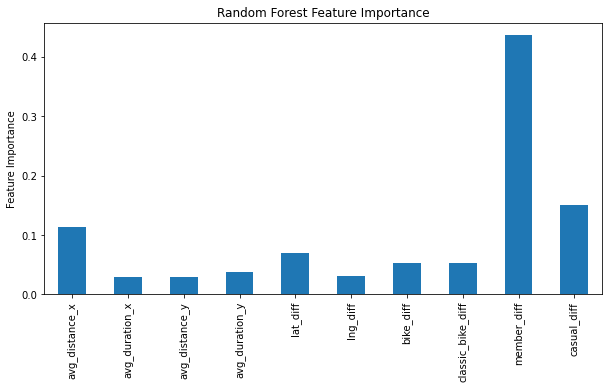

In [19]:
# Feature importances (Random Forest)
rf_model = models[1][1]
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.plot(kind='bar', figsize=(10, 5))
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()
